In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import PIL
import re
import utils

%matplotlib inline
plt.ion()

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

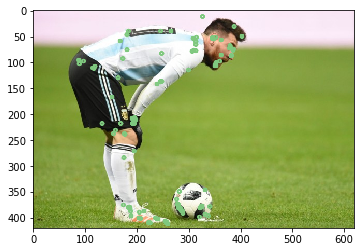

In [2]:
# Implement pretrained keypoint_rcnn for keypoint detection on human and quadruped images without any traning
# TODO: Display 5 images of keypoints on humans
model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True)

model.eval()

image = cv2.imread('images/humans/human1.jpg')
image_tensor = transforms.functional.to_tensor(image)

output = model([image_tensor])

for instance in output[0]["keypoints"]:
    for kp in instance:
        cv2.circle(image, (int(kp[0]), int(kp[1])), int(3*kp[2]), (127, 200, 127), 2, cv2.LINE_AA)
    
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

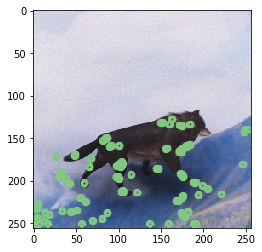

In [5]:
# TODO: Display 5 images of keypoints on wolf
image = cv2.imread('images/quadruped/wolf1.png')
image_tensor = transforms.functional.to_tensor(image)

output = model([image_tensor])

for instance in output[0]["keypoints"]:
    for kp in instance:
        cv2.circle(image, (int(kp[0]), int(kp[1])), int(3*kp[2]), (127, 200, 127), 2, cv2.LINE_AA)
    
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
#Load and pre-process dataset for input to keypoint_rcnn model as required in https://github.com/pytorch/vision/blob/master/torchvision/models/detection/keypoint_rcnn.py
class LoadQuadrupedDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.images = list(os.listdir(os.path.join(root)))

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        # [Images]
        img_path = os.path.join(self.root, self.images[index])
        img = PIL.Image.open(img_path).convert("RGB")
        index =  index + 1 # Adding a 1 to the index as we ignore the first index of the file as it contains the joints name

        # [Targets]
        annotation_path = 'Datasets/Synthetic_Wolf_1__2019_07_18/Annotation/BonePositions.txt'
        file = open(annotation_path, "r")

        target = {}
        keypoints_data = []
        boxes_data = []
        
        for i, line in enumerate(file):
            # Skip the first iteation as it contains the joints name from the text file (BonePositions)
            if i == 0:
                continue
                
            # Get the keypoint data for the right frame represented by the index
            if i == index:
                individual_cordinates = line.split(' ')[0]
                individual_cordinates = re.split(r'\t+', individual_cordinates)
                
                for j, cordinate in enumerate(individual_cordinates):
                    # Skip even iterations as including it duplicates (x,y) cordinates entry
                    if j%2 == 0:
                        continue
                    # Skip the value in the first index of the list as this is the frame number    
                    if j is not 0:
                        keypoints_data.append([float(cordinate), float(individual_cordinates[j + 1]), float(1)])
                        if j is 1:
                            # Obtain the boxes of each samples, theese are: xmin, xmax, ymin, ymax
                            xmin = float(cordinate)
                            xmax = float(cordinate)
                            ymin = float(individual_cordinates[j + 1])
                            ymax = float(individual_cordinates[j + 1])
                            boxes_data =  np.array([float(xmin), float(ymin), float(xmax), float(ymax)])
                        else:
                            xmin = xmin if (xmin < float(cordinate)) else float(cordinate)
                            xmax = xmax if (xmax > float(cordinate)) else float(cordinate)
                            ymin = ymin if (ymin < float(individual_cordinates[j + 1])) else float(individual_cordinates[j + 1])
                            ymax = ymax if (ymax > float(individual_cordinates[j + 1])) else float(individual_cordinates[j + 1])
                            boxes_data =  np.array([float(xmin), float(ymin), float(xmax), float(ymax)])
            
                # Break out of loop once desired image and infomration are collected
                break
                
        keypoints = torch.as_tensor(keypoints_data, dtype=torch.float32)
        boxes = torch.as_tensor(boxes_data, dtype=torch.float32)
        target["labels"] = torch.ones((1,), dtype=torch.int64)
        target["keypoints"] = keypoints.unsqueeze(0)
        target["boxes"] = boxes.unsqueeze(0)

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        # Closing opened file
        file.close()
        
        # Delete unused variables
        del keypoints_data
        del boxes_data
        del img_path
        
        return img, target

In [ ]:
import transforms as T
    
def get_transform(train):
    transforms_container = []
    transforms_container.append(T.ToTensor())
    return T.Compose(transforms_container)

In [ ]:
# Training using inbuilt method
from engine import train_one_epoch, evaluate

dataset = LoadQuadrupedDataset('Datasets/Synthetic_Wolf_1__2019_07_18/Images/1', get_transform(train=True))
datasetTest = LoadQuadrupedDataset('Datasets/Synthetic_Wolf_1__2019_07_18/Images/1', get_transform(train=False))

# Spliting dataset into train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
datasetTest = torch.utils.data.Subset(datasetTest, indices[-50:])

dataLoader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=utils.collate_fn)
dataLoaderTest = torch.utils.data.DataLoader(datasetTest, batch_size=1, shuffle=False, num_workers=0, collate_fn=utils.collate_fn)

# Laod model fort training
keypoint_model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True, min_size=640)
for param in keypoint_model.parameters():
        param.requires_grad = False
        
keypoint_model.roi_heads.keypoint_predictor = models.detection.keypoint_rcnn.KeypointRCNNPredictor(512, 26)
keypoint_model = keypoint_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(keypoint_model.roi_heads.keypoint_predictor.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
num_epochs = 1

for epoch in range(num_epochs):
    train_one_epoch(keypoint_model, optimizer, dataLoader, device, epoch, print_freq=10)
    lr_scheduler.step()
    torch.cuda.empty_cache()
    # Evaluate on the test dataset
    evaluate(keypoint_model, dataLoaderTest, device=device)


In [ ]:
# Test tge newly trained model on images of quadrupeds
# TODO: Display 5 images of keypoints on wolf
image = cv2.imread('images/quadruped/wolf1.jpg')
image_tensor = transforms.functional.to_tensor(image)

output = model([image_tensor])

for instance in output[0]["keypoints"]:
    for kp in instance:
        cv2.circle(image, (int(kp[0]), int(kp[1])), int(3*kp[2]), (127, 200, 127), 2, cv2.LINE_AA)
    
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))